# 예측

출처: https://github.com/jaron/deep-listening/blob/master/2-us8k-ffn-train-predict.ipynb


Workbook 2 - Training a Feed-Forward Neural Network using UrbanSound8K audio data

> 통합 문서 2 - UrbanSound8K 오디오 데이터를 사용하여 피드 포워드 신경망 훈련

This loads the features we extracted using librosa (see workbook 1), and uses them to train a Feed-Forward Network, a simple deep neural net with a few hidden layers, and then predict the class of a set of previously unheard audio files. You will need librosa, keras and tensorflow installed to run this code, and the latest version of scikit-learn (currently 0.18.1).

> 이렇게 하면 librosa (통합 문서 1 참조)를 사용하여 추출한 기능을 로드하고 숨겨진 레이어가 있는 간단한 신경망인 Feed-Forward 네트워크를 학습한 다음 이전에 들리지 않은 오디오 파일 세트의 클래스를 예측할 수 있습니다. 이 코드를 실행하기 위해 설치된 librosa, keras 및 tensorflow와 최신 scikit-learn 버전이 필요합니다.

## 패키지 설치
```shell
pip install keras tensorflow sklearn h5py
```


In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

This code below loads previously computed numpy features for each of the 10 folds, we'll use the first 8 for training, and keep one back for validation and one for testing.

> 이 코드는 이전에 계산된 10개의 폴드에 대해서 numpy 피쳐를 로드합니다. 
> 처음 8개는 트레이닝에 사용하며 1개는 유효성 확인을 위해서 마지막 1개는 테스트를 위해서 유지합니다. 


In [2]:
data_dir = 'data/us8k-np-ffn'

def add_folds():
    subsequent_fold = False
    for k in range(1, 9):
        fold_name = 'fold' + str(k)
        print('Adding ' + fold_name)
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        loaded_features = np.load(feature_file)
        loaded_labels = np.load(labels_file)
        print("New Features: ", loaded_features.shape)
        
        if subsequent_fold:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            subsequent_fold = True
        
    return features, labels    
    
train_x, train_y = add_folds()

Adding fold1
New Features:  (871, 193)
Adding fold2
New Features:  (888, 193)
Adding fold3
New Features:  (925, 193)
Adding fold4
New Features:  (990, 193)
Adding fold5
New Features:  (936, 193)
Adding fold6
New Features:  (823, 193)
Adding fold7
New Features:  (838, 193)
Adding fold8
New Features:  (806, 193)


In [3]:
valid_fold_name = 'fold9'
feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
valid_x = np.load(feature_file)
valid_y = np.load(labels_file)

# and a fold for testing
test_fold_name = 'fold10'
feature_file = os.path.join(data_dir, test_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, test_fold_name + '_y.npy')
test_x = np.load(feature_file)
test_y = np.load(labels_file)

print("Training Set Features: {} Labels: {}".format(str(train_x.shape), str(train_y.shape)))
print("Validation Set Features: {} Labels: {}".format(str(valid_x.shape), str(valid_y.shape)))
print("Test Set Features: {} Labels: {}".format(str(test_x.shape), str(test_y.shape)))

Training Set Features: (7077, 193) Labels: (7077, 10)
Validation Set Features: (816, 193) Labels: (816, 10)
Test Set Features: (837, 193) Labels: (837, 10)


In [4]:
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

E:\4.SDK\Miniconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
def assure_path_exists(path):
    mydir = os.path.join(os.getcwd(), path)
    if not os.path.exists(mydir):
        os.makedirs(mydir)

# neural network dimensions
n_dim = train_x.shape[1]
n_classes = train_y.shape[1]
n_hidden_units_1 = n_dim
n_hidden_units_2 = 400 # approx n_dim + 2
n_hidden_units_3 = 200 # half of layer 2

checkpoint_dir = "model"
assure_path_exists(checkpoint_dir)

print("Features: {} Classes: {}".format(n_dim, n_classes))

Features: 193 Classes: 10


In [9]:
train_x.shape

(7077, 193)

In [49]:
tf.set_random_seed(0)
np.random.seed(0)

def create_model(activation_function="relu", init_type="normal", optimiser="Adamax", dropout_rate=0.5):
    model = Sequential()
    # layer 1
    model.add(Dense(n_hidden_units_1, input_dim=n_dim))
    # layer 2
    model.add(Dense(n_hidden_units_2, init=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    # layer 3
    model.add(Dense(n_hidden_units_3, init=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    # output layer
    model.add(Dense(n_classes, init=init_type, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model

# a stopping function to stop trainning before we excessively overfit to the training set
earlystop = EarlyStopping(monitor = 'val_loss', patience=10, verbose =1, mode='auto')

model = create_model()

history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[earlystop], nb_epoch=30, batch_size=24)            

E:\4.SDK\Miniconda3_64\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", kernel_initializer="normal")`
  if __name__ == '__main__':
E:\4.SDK\Miniconda3_64\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
E:\4.SDK\Miniconda3_64\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="softmax", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
E:\4.SDK\Miniconda3_64\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 7077 samples, validate on 816 samples
Epoch 1/30
7077/7077 [==============================] - 2s 328us/step - loss: 3.5785 - acc: 0.2840 - val_loss: 1.6654 - val_acc: 0.3652
Epoch 2/30
7077/7077 [==============================] - 1s 177us/step - loss: 1.9735 - acc: 0.3944 - val_loss: 1.5826 - val_acc: 0.3922
Epoch 3/30
7077/7077 [==============================] - 1s 176us/step - loss: 1.7006 - acc: 0.4614 - val_loss: 1.5447 - val_acc: 0.4326
Epoch 4/30
7077/7077 [==============================] - 1s 185us/step - loss: 1.5371 - acc: 0.5053 - val_loss: 1.4740 - val_acc: 0.4755
Epoch 5/30
7077/7077 [==============================] - 1s 198us/step - loss: 1.4105 - acc: 0.5494 - val_loss: 1.5102 - val_acc: 0.4877
Epoch 6/30
7077/7077 [==============================] - 1s 193us/step - loss: 1.3312 - acc: 0.5689 - val_loss: 1.5067 - val_acc: 0.5147
Epoch 7/30
7077/7077 [==============================] - 1s 182us/step - loss: 1.2175 - acc: 0.6110 - val_loss: 1.4132 - val_acc: 0.5637
E

## Measuring Accuracy

In [50]:
from sklearn import metrics
from keras.utils import np_utils

# obtain the prediction probabilities
y_prob = model.predict_proba(test_x, verbose=0)
# y_pred = np_utils.probas_to_classes(y_prob)
y_pred = model.predict_classes(test_x)
y_true = np.argmax(test_y, 1)

roc = metrics.roc_auc_score(test_y, y_prob)
print("ROC: ", round(roc, 2))

# evaluate the model
score, accuracy = model.evaluate(test_x, test_y, batch_size=32)
print("Accuracy = {: .2f}".format(accuracy))

p, r, f, s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print('F-Score: ', round(f, 2))

ROC:  0.91
837/837 [==============================] - 0s 51us/step
Accuracy =  0.60
F-Score:  0.6


I used GridSearch (see section below) to investigate the best combinations of parameters, such as optimisers, dropout rates, hidden layers and activation functions. With 2 hidden layers the best accuracy I observed was an F-score of 0.59 (ROC = 0.89)

With 3 hidden layers the best accuracy seen was an F-score of 0.645 (ROC=0.92), using the Adamax optimiser and a dropout rate of 0.5. There did not seem to be any benefit in using 4 hidden layers, the accuracy seemed equivalent to that achieved with just 2 hidden layers. (As the gradient computation is stochastic, you might get slightly different values when you run this code).

ROC curves are typically used in binary classification, so to apply this measure to multi-class classification, it's first necessary to convert the predictions into boolean values, each representing positive or negative predictions for each possible class. This enables us to draw one ROC curve per class, or draw a composite ROC curve by using micro-averaging.

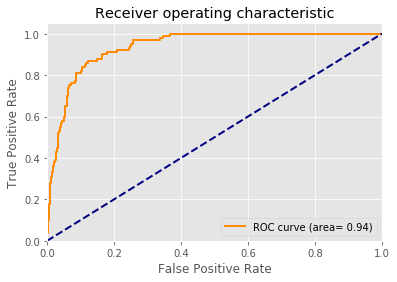

In [51]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(test_y.ravel(), y_prob.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area= %0.2f)' % roc_auc[2])
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
plt.show()

In [52]:
from sklearn.metrics import confusion_matrix

labels = ['aircon', 'horn', 'child', 'dog', 'drill', 'engine', 'gun', 'hammer', 'siren', 'music']
print("Confusion_matrix")
cm = confusion_matrix(y_true, y_pred)

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [7]) # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    ", empty_cell, end="")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="")
    print()
    # Print rows
    for i, label in enumerate(labels):
        print("     %{0}s".format(columnwidth) % label, end="")
        for j in range(len(labels)):
            cell = "%{0}s".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end="")
        print()

print_cm(cm, labels)

Confusion_matrix
             aircon   horn  child    dog  drill engine    gun hammer  siren  music
      aircon     60      0      1      0      0     21      0     14      2      2
        horn      4     25      0      0      2      0      0      1      0      1
       child      6      1     78     12      0      1      0      0      1      1
         dog      1      0     18     66      3      3      0      0      2      7
       drill      0      0      6     10     58      1      0     20      3      2
      engine     11      2      3     20      1     48      0      8      0      0
         gun      0      0      0     17      0      0     14      0      1      0
      hammer      5      0      4      0     21      0      0     65      0      1
       siren      8      1     22      7      6      0      0      0     38      1
       music     13      3     13      1     11      5      0      1      3     50


### Refinement and Optimisation

The performance of a deep neural network is highly dependent on many configurable hyper-parameters, values that govern how the model actually works, and which are not changed during the course of learning. Some of these parameters will have a greater influence than others. The classic machine learning solution to this challenge is GridSearch, to successively train separate instances of a model with distinct values of key parameters, and then compare the resulting accuracy scores to identify which combination of parameters has produced the best results.

Scikit-Learn provides GridSearch functionality that can be adapted for use with a neural network implemented using Keras, as described here: http://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/.

Because the training process is computationally intensive, and must be repeated for each combination of hyper-parameter values, optimisation can be a slow, time-consuming process. The code below shows how the 3-layer network was trained with different stochastic gradient optimisers (https://keras.io/optimizers/), and reveals which algorithms work best for this particular problem domain.



In [57]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm

activations = ['relu', 'tanh', 'linear']
batch_sizes = [10, 20, 30, 40, 50, 60]
epochs = [10, 20, 30]
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

optimisers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=24, verbose=0)

# define the grid search parameters
# just using one here for illustration, but add activation_function=activations
# or dropout_rate=dropout_rates to grid search on other parameters
param_grid = dict(optimiser=optimisers)
grid = GridSearchCV(estimator = model, param_grid=param_grid, n_jobs=1)

In [58]:
grid

GridSearchCV(cv=None, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000002A2344B9240>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'optimiser': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)